# Gensim Word2Vec Tutorial


<img src="https://images.freeimages.com/images/large-previews/2b9/letters-1-yes-1188348.jpg" alt="drawing" width="350"/>

# Plan

1. [Briefing about Word2Vec](#Briefing-about-Word2Vec:)
    * [Purpose of the tutorial](#Purpose-of-the-tutorial:)
    * [Brief explanation](#Brief-explanation:)

2. [Getting Started](#Getting-Started)
    * [Setting up the environment](#Setting-up-the-environment:)
    * [The data](#The-data:)
3. [Preprocessing](#Preprocessing)
    * [Cleaning](#Cleaning)
    * [Bigrams](#Bigrams)
    * [Most frequent words](#Most-Frequent-Words)
    
4. [Training the Model](#Training-the-model)
    * [Gensim Word2Vec Implementation](#Gensim-Word2Vec-Implementation:)
    * [Why I seperate the training of the model in 3 steps](#Why-I-seperate-the-training-of-the-model-in-3-steps:)
    * [Training the model](#Training-the-model)
        * [The parameters](#The-parameters)
        * [Building the vocabulary table](#Building-the-Vocabulary-Table)
        * [Training of the model](#Training-of-the-model)
        * [Saving the model](#Saving-the-model:)
5. [Exploring the Model](#Exploring-the-model)
    * [Most similar to](#Most-similar-to:)
    * [Similarities](#Similarities:)
    * [Odd-one-out](#Odd-One-Out:)
    * [Analogy difference](#Analogy-difference:)
    * [t-SNE visualizations](#t-SNE-visualizations:)
        * [10 Most similar words vs. 8 Random words](#10-Most-similar-words-vs.-8-Random-words:)
        * [10 Most similar words vs. 10 Most dissimilar](#10-Most-similar-words-vs.-10-Most-dissimilar:)
        * [10 Most similar words vs. 11th to 20th Most similar words](#10-Most-similar-words-vs.-11th-to-20th-Most-similar-words:)
6. [Final Thoughts](#Final-Thoughts)
7. [Material for more in depths understanding](#Material-for-more-in-depths-understanding:)
8. [Acknowledgements](#Acknowledgements)
9. [References](#References:)
10. [End](#End)

# Briefing about Word2Vec:

<img src="http://mccormickml.com/assets/word2vec/skip_gram_net_arch.png" alt="drawing" width="550"/>

[[1]](#References:)


## Purpose of the tutorial:
As I said before, this tutorial focuses on the right use of the Word2Vec package from the Gensim libray; therefore, I am not going to explain the concepts and ideas behind Word2Vec here. I am simply going to give a very brief explanation, and provide you with links to good, in depth tutorials.

## Brief explanation:

Word2Vec was introduced in two [papers](#Material-for-more-in-depths-understanding:) between September and October 2013, by a team of researchers at Google. Along with the papers, the researchers published their implementation in C. The Python implementation was done soon after the 1st paper, by [Gensim](https://radimrehurek.com/gensim/index.html). 

The underlying assumption of Word2Vec is that two words sharing similar contexts also share a similar meaning and consequently a similar vector representation from the model. For instance: "dog", "puppy" and "pup" are often used in similar situations, with similar surrounding words like "good", "fluffy" or "cute", and according to Word2Vec they will therefore share a similar vector representation.<br>

From this assumption, Word2Vec can be used to find out the relations between words in a dataset, compute the similarity between them, or use the vector representation of those words as input for other applications such as text classification or clustering.

# Getting Started


In [2]:
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

import spacy  # For preprocessing

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [3]:
df = pd.read_csv('../input/train.csv.zip')
df.shape

(404290, 6)

In [4]:
df.head()

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0

In [5]:
text = list(df['question1']) + list(df['question2'])

## Cleaning:
We are lemmatizing and removing the stopwords and non-alphabetic characters for each line of dialogue.

In [7]:
nlp = spacy.load("en_core_web_sm")

def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

Removes non-alphabetic characters:

In [15]:
brief_cleaning = [re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in text]

Taking advantage of spaCy .pipe() attribute to speed-up the cleaning process:

In [21]:
t = time()

txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning[:], batch_size=1000)]

print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 8.91 mins


Put the results in a DataFrame to remove missing values and duplicates:

In [22]:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(450979, 1)

## Bigrams:
We are using Gensim Phrases package to automatically detect common phrases (bigrams) from a list of sentences.
https://radimrehurek.com/gensim/models/phrases.html

The main reason we do this is to catch words like "mr_burns" or "bart_simpson" !

In [23]:
from gensim.models.phrases import Phrases, Phraser

As `Phrases()` takes a list of list of words as input:

In [24]:
sent = [row.split() for row in df_clean['clean']]

Creates the relevant phrases from the list of sentences:

In [25]:
phrases = Phrases(sent, min_count=30, progress_per=10000)

INFO - 00:37:29: collecting all words and their counts
INFO - 00:37:29: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 00:37:29: PROGRESS: at sentence #10000, processed 54506 words and 46005 word types
INFO - 00:37:29: PROGRESS: at sentence #20000, processed 109331 words and 82157 word types
INFO - 00:37:29: PROGRESS: at sentence #30000, processed 163902 words and 115246 word types
INFO - 00:37:29: PROGRESS: at sentence #40000, processed 218787 words and 146858 word types
INFO - 00:37:29: PROGRESS: at sentence #50000, processed 273622 words and 177079 word types
INFO - 00:37:29: PROGRESS: at sentence #60000, processed 328871 words and 206229 word types
INFO - 00:37:29: PROGRESS: at sentence #70000, processed 384144 words and 234577 word types
INFO - 00:37:29: PROGRESS: at sentence #80000, processed 439434 words and 262430 word types
INFO - 00:37:29: PROGRESS: at sentence #90000, processed 494812 words and 289860 word types
INFO - 00:37:30: PROGRESS: at sentence #10

The goal of Phraser() is to cut down memory consumption of Phrases(), by discarding model state not strictly needed for the bigram detection task:

In [26]:
bigram = Phraser(phrases)

INFO - 00:37:38: source_vocab length 1076718
INFO - 00:37:44: Phraser built with 1937 phrasegrams


Transform the corpus based on the bigrams detected:

In [27]:
sentences = bigram[sent]

## Most Frequent Words:
Mainly a sanity check of the effectiveness of the lemmatization, removal of stopwords, and addition of bigrams.

In [28]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

67186

In [29]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['good',
 'india',
 'like',
 'people',
 'way',
 'work',
 'difference',
 'use',
 'time',
 'want']

# Training the model
## Gensim Word2Vec Implementation:
We use Gensim implementation of word2vec: https://radimrehurek.com/gensim/models/word2vec.html

In [30]:
import multiprocessing

from gensim.models import Word2Vec

## Why I seperate the training of the model in 3 steps:
I prefer to separate the training in 3 distinctive steps for clarity and monitoring.
1. `Word2Vec()`: 
>In this first step, I set up the parameters of the model one-by-one. <br>I do not supply the parameter `sentences`, and therefore leave the model uninitialized, purposefully.
2. `.build_vocab()`: 
>Here it builds the vocabulary from a sequence of sentences and thus initialized the model. <br>With the loggings, I can follow the progress and even more important, the effect of `min_count` and `sample` on the word corpus. I noticed that these two parameters, and in particular `sample`, have a great influence over the performance of a model. Displaying both allows for a more accurate and an easier management of their influence.
3. `.train()`:
>Finally, trains the model.<br>
The loggings here are mainly useful for monitoring, making sure that no threads are executed instantaneously.

In [32]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

## The parameters:

* `min_count` <font color='purple'>=</font> <font color='green'>int</font> - Ignores all words with total absolute frequency lower than this - (2, 100)


* `window` <font color='purple'>=</font> <font color='green'>int</font> - The maximum distance between the current and predicted word within a sentence. E.g. `window` words on the left and `window` words on the left of our target - (2, 10)


* `size` <font color='purple'>=</font> <font color='green'>int</font> - Dimensionality of the feature vectors. - (50, 300)


* `sample` <font color='purple'>=</font> <font color='green'>float</font> - The threshold for configuring which higher-frequency words are randomly downsampled. Highly influencial.  - (0, 1e-5)


* `alpha` <font color='purple'>=</font> <font color='green'>float</font> - The initial learning rate - (0.01, 0.05)


* `min_alpha` <font color='purple'>=</font> <font color='green'>float</font> - Learning rate will linearly drop to `min_alpha` as training progresses. To set it: alpha - (min_alpha * epochs) ~ 0.00


* `negative` <font color='purple'>=</font> <font color='green'>int</font> - If > 0, negative sampling will be used, the int for negative specifies how many "noise words" should be drown. If set to 0, no negative sampling is used. - (5, 20)


* `workers` <font color='purple'>=</font> <font color='green'>int</font> - Use these many worker threads to train the model (=faster training with multicore machines)

In [33]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

## Building the Vocabulary Table:
Word2Vec requires us to build the vocabulary table (simply digesting all the words and filtering out the unique words, and doing some basic counts on them):

In [34]:
t = time()
# 我爱中国 我 爱 中国
w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 00:38:18: collecting all words and their counts
INFO - 00:38:18: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 00:38:19: PROGRESS: at sentence #10000, processed 49979 words, keeping 10771 word types
INFO - 00:38:19: PROGRESS: at sentence #20000, processed 100303 words, keeping 15315 word types
INFO - 00:38:19: PROGRESS: at sentence #30000, processed 150552 words, keeping 18698 word types
INFO - 00:38:19: PROGRESS: at sentence #40000, processed 201320 words, keeping 21549 word types
INFO - 00:38:19: PROGRESS: at sentence #50000, processed 251943 words, keeping 24007 word types
INFO - 00:38:19: PROGRESS: at sentence #60000, processed 303077 words, keeping 26153 word types
INFO - 00:38:19: PROGRESS: at sentence #70000, processed 354302 words, keeping 28142 word types
INFO - 00:38:19: PROGRESS: at sentence #80000, processed 405525 words, keeping 30041 word types
INFO - 00:38:20: PROGRESS: at sentence #90000, processed 456828 words, keeping 31823 word types

Time to build vocab: 0.12 mins


## Training of the model:
_Parameters of the training:_
* `total_examples` <font color='purple'>=</font> <font color='green'>int</font> - Count of sentences;
* `epochs` <font color='purple'>=</font> <font color='green'>int</font> - Number of iterations (epochs) over the corpus - [10, 20, 30]

In [35]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, 
                epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 00:38:46: training model with 11 workers on 10918 vocabulary and 300 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2
INFO - 00:38:48: EPOCH 1 - PROGRESS: at 9.69% examples, 123632 words/s, in_qsize 0, out_qsize 0
INFO - 00:38:49: EPOCH 1 - PROGRESS: at 24.36% examples, 158235 words/s, in_qsize 0, out_qsize 0
INFO - 00:38:50: EPOCH 1 - PROGRESS: at 38.82% examples, 168596 words/s, in_qsize 0, out_qsize 0
INFO - 00:38:51: EPOCH 1 - PROGRESS: at 53.54% examples, 173224 words/s, in_qsize 0, out_qsize 1
INFO - 00:38:52: EPOCH 1 - PROGRESS: at 67.00% examples, 168223 words/s, in_qsize 0, out_qsize 1
INFO - 00:38:53: EPOCH 1 - PROGRESS: at 81.07% examples, 173094 words/s, in_qsize 0, out_qsize 0
INFO - 00:38:54: EPOCH 1 - PROGRESS: at 94.71% examples, 175528 words/s, in_qsize 0, out_qsize 0
INFO - 00:38:54: worker thread finished; awaiting finish of 10 more threads
INFO - 00:38:54: worker thread finished; awaiting finish of 9 more threads
INFO - 00:38:54: worker thread fini

Time to train the model: 3.88 mins


As we do not plan to train the model any further, we are calling init_sims(), which will make the model much more memory-efficient:

In [36]:
w2v_model.init_sims(replace=True)

INFO - 00:42:58: precomputing L2-norms of word weight vectors


# Exploring the model

In [37]:
w2v_model.wv.most_similar(positive=["china"])
# china -》 300
# taiwan -》 300

# A B C D.

# my country is china.
# my city is beijing.

[('taiwan', 0.5575523972511292),
 ('country', 0.555629312992096),
 ('russia', 0.5395889282226562),
 ('mongolia', 0.5373038053512573),
 ('pakistan', 0.5337280631065369),
 ('tibet', 0.5190942287445068),
 ('chinese', 0.5075892210006714),
 ('mainland_china', 0.49450621008872986),
 ('america', 0.49039390683174133),
 ('japan', 0.4894120395183563)]

In [69]:
[x[0] for x in w2v_model.wv.most_similar(positive=["china"])]

['taiwan',
 'country',
 'russia',
 'mongolia',
 'pakistan',
 'tibet',
 'chinese',
 'mainland_china',
 'america',
 'japan']

In [40]:
w2v_model.wv.most_similar(positive=["usa"])

[('canada', 0.6054026484489441),
 ('u_s', 0.5804586410522461),
 ('germany', 0.5616978406906128),
 ('uk', 0.5511983633041382),
 ('australia', 0.510536789894104),
 ('india', 0.503986120223999),
 ('country', 0.5027014017105103),
 ('united_state', 0.4979032278060913),
 ('abroad', 0.47457489371299744),
 ('ukraine', 0.474430650472641)]

In [41]:
w2v_model.wv.most_similar(positive=["uk"])

[('canada', 0.5552400350570679),
 ('usa', 0.5511983633041382),
 ('australia', 0.5467010736465454),
 ('work_permit', 0.5066534876823425),
 ('new_zealand', 0.4625726342201233),
 ('ireland', 0.46158888936042786),
 ('canada_australia', 0.46132782101631165),
 ('netherland', 0.45171695947647095),
 ('germany', 0.44295215606689453),
 ('northern_ireland', 0.4395149350166321)]

## Similarities:

In [42]:
w2v_model.wv.similarity("usa", 'uk')

0.5511984

In [44]:
w2v_model.wv.similarity('china', 'beijing')

0.3828935

Maggie is indeed the most renown baby in the Simpsons!

In [45]:
w2v_model.wv.similarity('bart', 'nelson')

KeyError: "word 'bart' not in vocabulary"

In [47]:
w2v_model.wv.doesnt_match(['beijing', 'usa', 'taiwan'])

'usa'

In [49]:
w2v_model.wv.most_similar(positive=["beijing", "taiwan"], negative=["usa"], topn=3)

[('shanghai', 0.5763319134712219),
 ('mandarin', 0.44238629937171936),
 ('macau', 0.4212847054004669)]

In [50]:
# word2vec 语料
# word2vec：可以考虑直接用预训练的，也可以自己在比赛数据集上进行训练
# 如果数据集原始文本是明文，如果是中英文，可以使用预训练
# 如果数据集文本是加密或者直接id或者数值，从头训练



# 文本：单词组成的
# A B C D
w2v_model.wv.most_similar(positive=["usa", "uk"], negative=["china"], topn=3)

[('work_permit', 0.5489858984947205),
 ('canada', 0.5458544492721558),
 ('abroad', 0.44898563623428345)]

### t-SNE visualizations:
t-SNE is a non-linear dimensionality reduction algorithm that attempts to represent high-dimensional data and the underlying relationships between vectors in a lower-dimensional space.<br>
Here is a good tutorial on it: https://medium.com/@luckylwk/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b

In [51]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [57]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=20).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    # 用来做高维数据在低纬空间的可视化。
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))
    

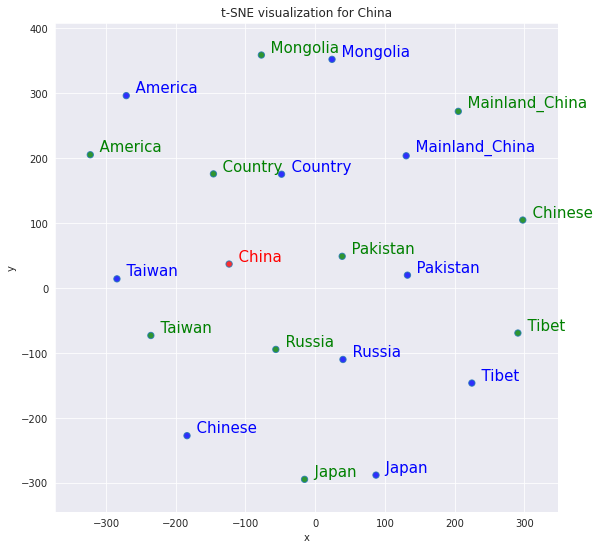

In [70]:
tsnescatterplot(w2v_model, 'china', ['taiwan',
 'country',
 'russia',
 'mongolia',
 'pakistan',
 'tibet',
 'chinese',
 'mainland_china',
 'america',
 'japan'])

Interestingly, the 10 most similar words to Homer ends up around him, so does Apu and (sideshow) Bob, two recurrent characters.

## 10 Most similar words vs. 10 Most dissimilar

This time, let's compare where the vector representation of Maggie and her 10 most similar words from the model lies compare to the vector representation of the 10 most dissimilar words to Maggie:

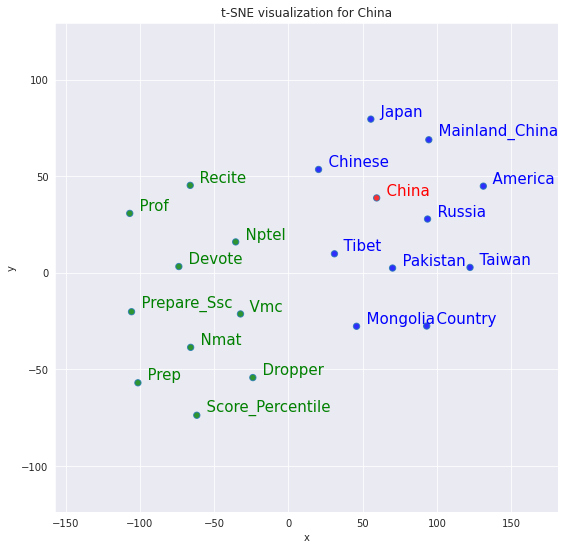

In [64]:
tsnescatterplot(w2v_model, 'china', 
    [i[0] for i in w2v_model.wv.most_similar(negative=["china"])])

Neat! Maggie and her most similar words form a distinctive cluster from the most dissimilar words, it is a really encouraging plot!

## 10 Most similar words vs. 11th to 20th Most similar words:

Finally, we are going to plot the most similar words to Mr. Burns ranked 1st to 10th versus the ones ranked 11th to 20th:

(PS: Mr. Burns became mr_burn after the preprocessing)

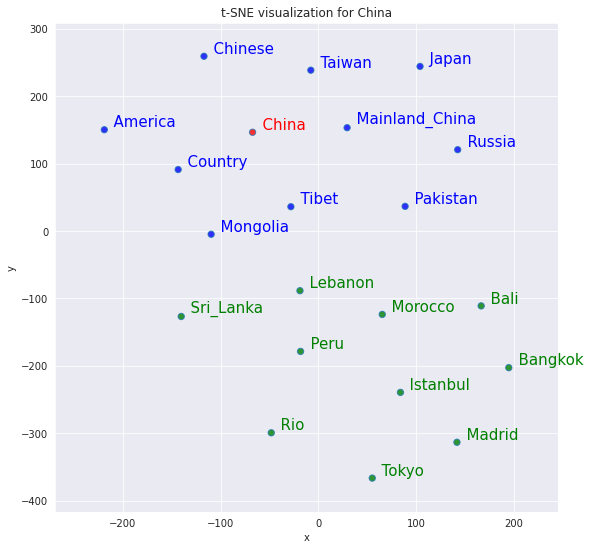

In [66]:
tsnescatterplot(w2v_model, "china", 
                [t[0] for t in w2v_model.wv.most_similar(positive=["beijing"], topn=20)][10:])

In [67]:
w2v_model['china']
# 1 * 300， 300 维度的向量

# gensim

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([ 0.03190469,  0.0514457 ,  0.03489973, -0.00226157, -0.04576773,
       -0.0966315 ,  0.0433302 , -0.00256622,  0.06819431,  0.04398138,
        0.00117546,  0.01234714,  0.06058068, -0.0739915 ,  0.10896028,
       -0.01504975, -0.06281856, -0.02183235,  0.09705329, -0.06961539,
        0.02724478, -0.02195147, -0.03082209, -0.04559079, -0.0145348 ,
       -0.03722186, -0.04337217, -0.01647208,  0.08081901,  0.0657801 ,
       -0.09981885, -0.04685086,  0.00867913, -0.04524508,  0.06209907,
        0.01549737,  0.04564739,  0.00230835,  0.00723173, -0.01437727,
        0.0007424 ,  0.10954895, -0.05165685,  0.07322949,  0.02619234,
        0.03168584, -0.0290453 ,  0.04586958, -0.06357666,  0.0187964 ,
        0.00549859,  0.06177244,  0.01185178,  0.0035712 ,  0.04112413,
        0.04328385, -0.08012891,  0.02444973, -0.02712448,  0.02556386,
        0.06171701,  0.02781216, -0.03739694,  0.01743969, -0.00764887,
        0.05081192, -0.0586493 ,  0.10461289,  0.16260093, -0.10

In [2]:
import numpy as np
import pandas as pd 
from gensim import models

def to_text_vector(txt, model):
    '''
        将文本txt转化为文本向量
    '''
    words = txt.split(',') 
    array = np.asarray([model.wv[w] for w in words if w in words],dtype='float32')   
    return array.mean(axis=0)

## 案例
sentences = ["1,2,3",'3,4,1','1,4,2']
model = models.Word2Vec(sentences, workers=8, min_count = 1,  size=10, window = 2)
to_text_vector(txt="1,2,3", model= model)

array([-0.00731579,  0.00303937, -0.0067821 , -0.00257837,  0.01081794,
       -0.00066849, -0.01786311,  0.01484739, -0.01607772,  0.02319482],
      dtype=float32)